# Training a VAE for Molecule Generation

Installing required libraries

In [2]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install pandas
!pip install matplotlib
!pip install tqdm
!pip install scipy
!pip install seaborn
!pip install scikit-learn
!pip install rdkit

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu118
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Importing Libraries

In [2]:
#General Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
import os
import random
import sys
random.seed(42)  # For reproducibility

warnings.filterwarnings('ignore')

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
torch.manual_seed(42)  # For reproducibility

# Chemistry
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdDistGeom,QED
from rdkit import RDLogger
from rdkit.Chem import RDConfig
sas_path = os.path.join(RDConfig.RDContribDir, 'SA_Score')
sys.path.append(sas_path)
# Suppress RDKit warnings and error messages
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)  # Only show critical errors
from rdkit.Chem import rdMolDescriptors

from IPython.display import display

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'GPU' if torch.cuda.is_available() else 'CPU'}")

All libraries imported successfully!
PyTorch version: 2.7.1+cu118
Device available: GPU


## Important hyperparameters

If model takes to long to train,try setting FRAC_OF_TRAINING_SAMPLES = 0.1 . 

In [3]:
FRAC_OF_TRAINING_SAMPLES = 0.1 #while experimenting,for quick iteration,for real training = 1.0
BATCH_SIZE = 64 #Alternate values = 64,256
# Training parameters
NUM_EPOCHS = 20 # Can change if required
LEARNING_RATE = 1e-3
KLD_START_EPOCH = 15 # Start annealing KLD loss
KLD_END_EPOCH = 20 # Finish annealing KLD loss
PROP_START_EPOCH = 10 # Start annealing property loss
PROP_END_EPOCH = 20 # Finish annealing property loss - can be used for conditional generation
# Early Stopping parameters
MODEL_SAVE_PATH = "vae_model_epoch_.pth" # Path to save the best model
NUM_SAMPLES_TO_GENERATE = 1000 # Number of samples to generate from each latent point 
                                #during stochastic writeout
GENERATION_TEMPERATURE = 1.0 # Control creativity (lower = more typical, higher = more diverse)

## Data Analysis and Preprocessing

In this section, we visualise some statistics about the dataset like distributions of properties,length of smiles strings, no of atoms in molecules.

Dataset loaded with 249455 samples and 4 features.
                                              smiles     logP       qed  \
0  C[NH+]1CCC(NC(=O)[C@H]2CCN(c3ccc(Cl)c(Cl)c3)C2...  1.13960  0.793487   
1  C[C@H]1C[C@H]1C(=O)N1CCN(C(=O)NCC(C)(C)[NH+]2C...  0.34360  0.784932   
2   Cc1ccc([C@@H]2CSCCN2Cc2cc3cnn(C(C)C)c3nc2Cl)o1\n  4.85712  0.569373   
3                              C=CCc1ccccc1OC(C)=O\n  2.34040  0.401613   
4  C[C@@H](c1nccs1)N(C)C(=O)c1cccc(NC(=O)C2CCCC2)...  4.10500  0.843003   

        SAS  
0  3.843395  
1  4.232355  
2  3.463493  
3  1.943724  
4  2.639230  


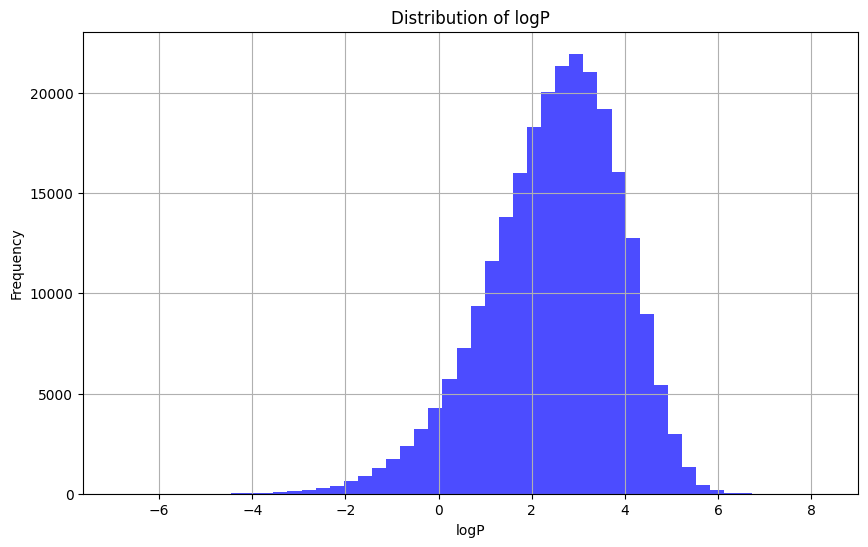

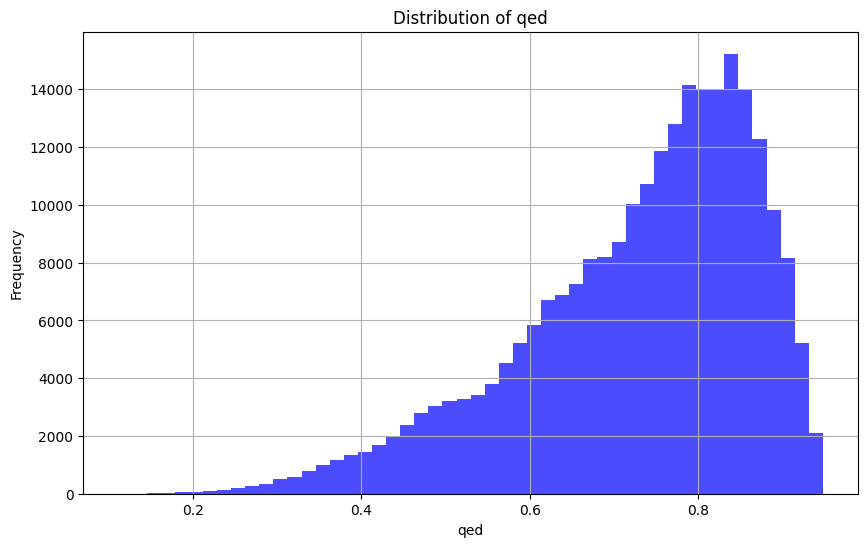

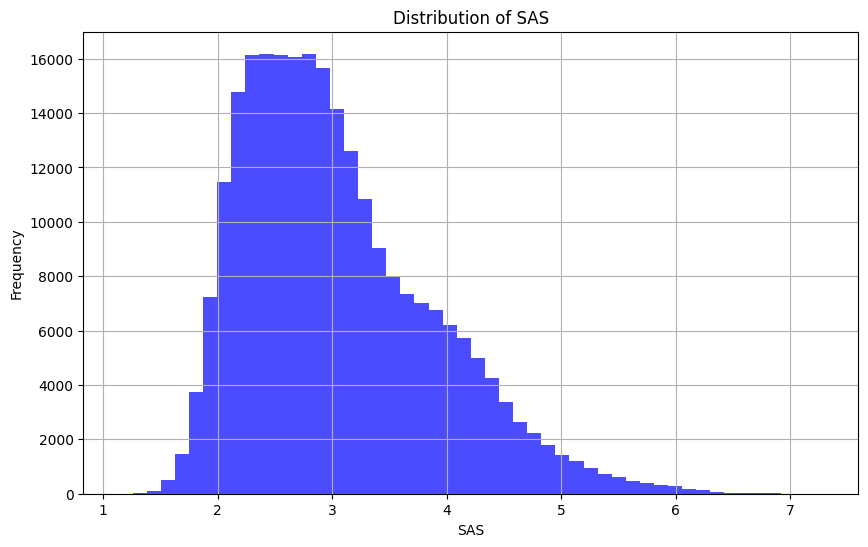

In [4]:
df = pd.read_csv('250k_rndm_zinc_drugs_clean_3.csv')
df = df.sample(frac=1.0,random_state=42).reset_index(drop=True)  # Shuffle the dataset
print(f"Dataset loaded with {df.shape[0]} samples and {df.shape[1]} features.")
print(df.head())

#Data Visualization
plt.figure(figsize=(10, 6))
plt.hist(df['logP'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of logP')
plt.xlabel('logP')
plt.ylabel('Frequency')
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(df['qed'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of qed')
plt.xlabel('qed')
plt.ylabel('Frequency')
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(df['SAS'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of SAS')
plt.xlabel('SAS')
plt.ylabel('Frequency')
plt.grid()
plt.show()


Distribution of smiles string lengths and number of atoms in molecules

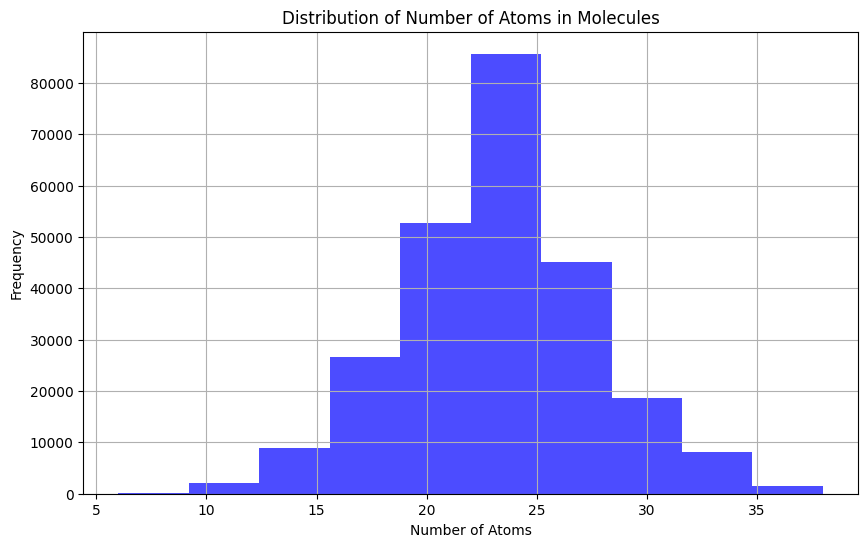

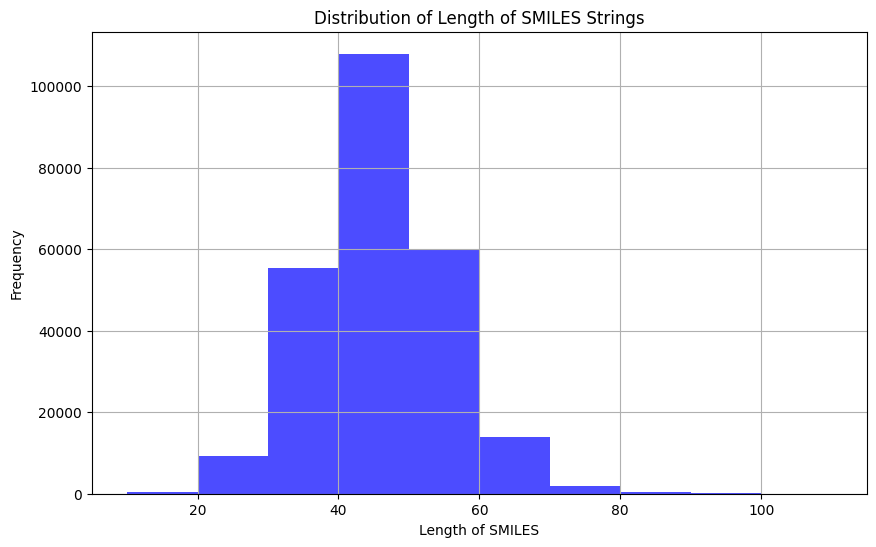

In [5]:
num_of_atoms = []
smiles_len = []
for smi in df['smiles']:
    smiles_len.append(len(smi))
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        num_of_atoms.append(mol.GetNumAtoms())
    else:
        num_of_atoms.append(0)  # Handle invalid SMILES
plt.figure(figsize=(10, 6))
plt.hist(num_of_atoms, bins=10, color='blue', alpha=0.7)
plt.title('Distribution of Number of Atoms in Molecules')
plt.xlabel('Number of Atoms')
plt.ylabel('Frequency')
plt.grid()
plt.show()
plt.figure(figsize=(10, 6))
plt.hist(smiles_len, bins=10, color='blue', alpha=0.7)
plt.title('Distribution of Length of SMILES Strings')
plt.xlabel('Length of SMILES')
plt.ylabel('Frequency')
plt.grid()
plt.show()

As we can see, most molecules are in 20 - 60 smiles length range,with maximum length being <120.

## Creating Vocabulary Of SMILES Tokens

We create a vocabulary to map each character seen in dataset to a number, which is used to generate corresponding one-hot vector.

In [6]:
vocab_dict ={" ": 0}  # Initialize with a pad token
counter = 1
# Create a vocabulary of unique tokens from the SMILES strings
for smile in df["smiles"]:
    for char in smile[:-1]: #last character is '\n'
        if char not in vocab_dict:
            vocab_dict[char] = counter
            counter += 1
vocab_dict['X'] = counter  # Add the end token to the vocabulary
counter += 1
vocab_dict['A'] = counter # Add the start token to the vocabulary
vocab_size = len(vocab_dict)
print(f"Vocabulary size: {vocab_size}")
print(f"Vocabulary: {vocab_dict}")

Vocabulary size: 37
Vocabulary: {' ': 0, 'C': 1, '[': 2, 'N': 3, 'H': 4, '+': 5, ']': 6, '1': 7, '(': 8, '=': 9, 'O': 10, ')': 11, '@': 12, '2': 13, 'c': 14, '3': 15, 'l': 16, 'S': 17, 'n': 18, 'o': 19, 's': 20, 'F': 21, '-': 22, 'B': 23, 'r': 24, '#': 25, '/': 26, '\\': 27, '4': 28, '5': 29, 'I': 30, 'P': 31, '6': 32, '7': 33, '8': 34, 'X': 35, 'A': 36}


In [7]:
indice_to_char = {v: k for k, v in vocab_dict.items()}
print(f"Inverse Vocabulary: {indice_to_char}") #to get character from index

Inverse Vocabulary: {0: ' ', 1: 'C', 2: '[', 3: 'N', 4: 'H', 5: '+', 6: ']', 7: '1', 8: '(', 9: '=', 10: 'O', 11: ')', 12: '@', 13: '2', 14: 'c', 15: '3', 16: 'l', 17: 'S', 18: 'n', 19: 'o', 20: 's', 21: 'F', 22: '-', 23: 'B', 24: 'r', 25: '#', 26: '/', 27: '\\', 28: '4', 29: '5', 30: 'I', 31: 'P', 32: '6', 33: '7', 34: '8', 35: 'X', 36: 'A'}


Now, we visualise frequency of different characters in dataset.

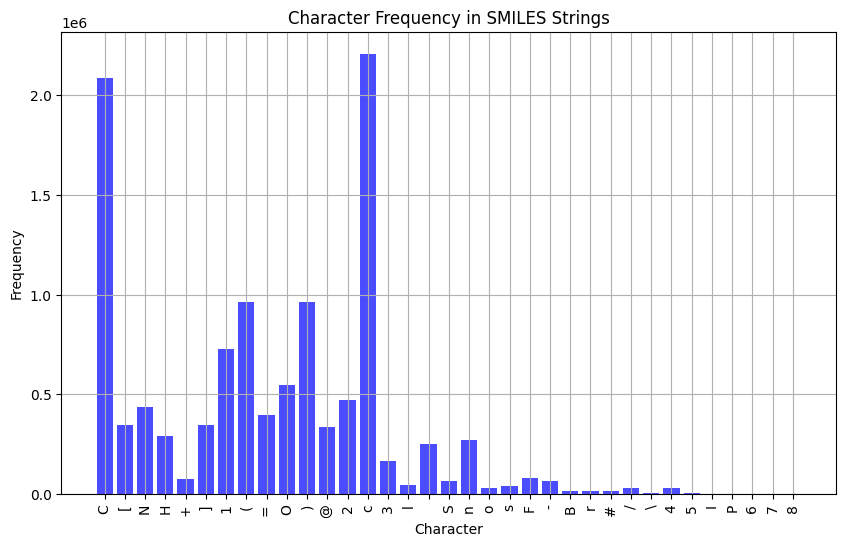

In [8]:
char_freq = {}
for smile in df["smiles"]:
    for char in smile:
        if char not in char_freq:
            char_freq[char] = 0
        char_freq[char] += 1
plt.figure(figsize=(10, 6))
plt.bar(char_freq.keys(), char_freq.values(), color='blue', alpha=0.7)
plt.title('Character Frequency in SMILES Strings')
plt.xlabel('Character')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.grid()
plt.show()

For preprocessing step, we add 'A' at start of each smile string and 'X' to end of each smile string. Also each smile string is padded to 120 length with padding index (0).

In [9]:
data_points = []  
for index,row in df.iterrows():
    smi ='A' + row['smiles'][:-1] + 'X'  # Ensure the end token is included
    num_smi = [vocab_dict[char] for char in smi]
    if len(num_smi) < 120:
        num_smi += [0] * (120 - len(num_smi)) # Padding to a fixed length of 120
    
    properties = torch.tensor([row['logP'], row['qed'], row['SAS']], dtype=torch.float)

    data_points.append({"smiles_indices": torch.tensor(num_smi,dtype=torch.long),'properties': properties})


In [10]:
data_points_train = random.sample(data_points, int(FRAC_OF_TRAINING_SAMPLES * len(data_points)))
print(f"Number of training samples: {len(data_points_train)}")
print(f"First training sample: {data_points_train[0]}")


Number of training samples: 24945
First training sample: {'smiles_indices': tensor([36,  1, 14,  7, 14, 14, 14,  8, 10,  2,  1, 12,  4,  6,  8,  1, 11,  1,
         8,  9, 10, 11,  3, 26,  3,  9,  1, 26, 14, 13, 14, 14, 14, 18, 14, 13,
        11, 14, 14,  7, 35,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]), 'properties': tensor([2.3076, 0.6773, 2.4346])}


In [11]:
data_points_train_smiles = [] #for storing smiles strings of training data points
for dp in data_points_train:
    smile = ""
    for idx in dp["smiles_indices"]:
        if idx==0 or idx==35:
            break
        smile += indice_to_char[idx.item()]
    data_points_train_smiles.append(smile)
print(f"First training SMILES: {data_points_train_smiles[0]}")
    

First training SMILES: ACc1ccc(O[C@H](C)C(=O)N/N=C/c2cccnc2)cc1


## Pytorch Dataset Class

In [13]:
class SmilesDataset(Dataset):
    def __init__(self, data_list):
        """
        Args:
            data_list (list): A list of dictionaries, where each dict contains
                              'smiles_indices' (tensor) and 'properties' (tensor).
                              'smiles_indices' are now variable length.
        """
        self.data = data_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]['smiles_indices'], self.data[idx]['properties']
    
train_dataset = SmilesDataset(data_points_train)

## Pytorch Dataloader

In [14]:
def smiles_collate_fn(batch):
    """
    Custom collate_fn for the DataLoader.
    """
    smiles_indices_batch = [item[0] for item in batch]
    properties_batch = [item[1] for item in batch]

    smiles_indices_batch_tensor = torch.stack(smiles_indices_batch)
    properties_batch_tensor = torch.stack(properties_batch)

    return smiles_indices_batch_tensor, properties_batch_tensor

train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              collate_fn=smiles_collate_fn)

## VAE Definition

This is our VAE class. Our VAE consists of an encoder and decoder.

The encoder consists of 3 1D Conv layers of filter sizes - 9,9,10 and kernel sizes - 9,9,11. This is followed by a fully connected layer which outputs 2 196 dimensional vectora.(mu and log_var).

We then use reparameterization trick to sample a new latent vector - z= mu + sigma*epsilon

This latent vector is then passed through the decoder,which consists of a GRU with three layers and hidden dimension of size 488. The input at each time step is latent vector concatenated with prediction of model at last time step - hence a vector of length latent_dim + vocab_size.

In [15]:
class SmilesVAE(nn.Module):
    def __init__(self, latent_dim, hidden_gru_dim, property_output_dim,
                 encoder_filter_sizes, encoder_kernel_sizes):
        super(SmilesVAE, self).__init__()
        self.vocab_size = 37
        self.max_len = 120
        self.latent_dim = latent_dim
        self.hidden_gru_dim = hidden_gru_dim
        self.property_output_dim = property_output_dim

        # --- Encoder Architecture ---
        self.conv_layers = nn.ModuleList() # 3 conv1d layers
        in_channels = self.vocab_size
        current_sequence_length = self.max_len

        for i in range(len(encoder_filter_sizes)):
            out_channels = encoder_filter_sizes[i]
            kernel_size = encoder_kernel_sizes[i]
            self.conv_layers.append(nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size))
            self.conv_layers.append(nn.ReLU())
            in_channels = out_channels
            current_sequence_length = current_sequence_length - kernel_size + 1

        self.encoder_fc_input_dim = in_channels * current_sequence_length
        self.fc_mu = nn.Linear(self.encoder_fc_input_dim, latent_dim) # Output mu vector
        self.fc_log_var = nn.Linear(self.encoder_fc_input_dim, latent_dim) # Output log_var vector

        # --- Decoder Architecture ---
        self.gru_layers = nn.GRU(self.latent_dim + self.vocab_size, hidden_gru_dim, num_layers=3, batch_first=True)
        self.fc_decoder_out = nn.Linear(hidden_gru_dim, self.vocab_size) # Output logits for each character

        # --- Property Prediction Head ---
        self.property_predictor = nn.Sequential(
            nn.Linear(latent_dim, 1000),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1000, property_output_dim)
        ) #for property optimisation

    def encode(self, x):
        """
        Encoder pass.
        Input: x (tensor): one-hot encoded SMILES, shape (batch_size, max_len, vocab_size)
        Output: mu (tensor), log_var (tensor): shape (batch_size, latent_dim)
        """
        # Permute input for Conv1d: (batch_size, vocab_size, max_len)
        x = x.permute(0, 2, 1)
        for layer in self.conv_layers:
            x = layer(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        """
        Reparameterization trick for sampling from the latent space.
        z = mu + std * epsilon, where epsilon ~ N(0, 1)
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, temperature=1.0, num_stochastic_samples_per_latent_point=1):
        """
        Input: z (tensor): latent vector, shape (initial_batch_size, latent_dim)
               teacher_forcing_inputs (tensor, optional): This argument is passed by the `forward` method
                                                         for training, but does NOT influence GRU input directly.
                                                         It signifies that all_logits_output should be collected
                                                         for reconstruction loss calculation.
               temperature (float): controls the randomness of sampling. Higher temp -> more random.
               num_stochastic_samples_per_latent_point (int): Number of times to perform stochastic writeout
                                                               for each latent point in z.
        Output: all_logits_output (tensor): raw logits for each character at each time step,
                                            shape (effective_batch_size, max_len, vocab_size).
        """
        initial_batch_size = z.size(0)
        device = z.device

        # Determine the effective batch size for decoding based on sampling requirement
        if num_stochastic_samples_per_latent_point > 1: 
            #during sampling,we generate multiple smiles strings for each latent vector
            z_expanded = z.repeat_interleave(num_stochastic_samples_per_latent_point, dim=0)
        else:
            z_expanded = z #during training

        current_batch_size = z_expanded.size(0)

        # Initialize GRU hidden state from expanded latent vectors
        h = torch.zeros(self.gru_layers.num_layers, current_batch_size, self.hidden_gru_dim).to(device)

        # Initialize first input character (start character = 'A')
        # current_input_char = torch.full((current_batch_size, 1, self.vocab_size),36, device=device)
        current_input_char = torch.zeros(current_batch_size, 1, self.vocab_size,device=device)
        
        # This tensor will store ALL logits generated at each time step
        all_logits_output = torch.zeros(current_batch_size, self.max_len, self.vocab_size, device=device)

        # Track which sequences are still active (haven't produced an end token)
        active_sequences = torch.ones(current_batch_size, dtype=torch.bool, device=device)

        for t in range(self.max_len):
            # If all sequences are done, break early
            if not active_sequences.any():
                break

            # Concatenate z_expanded with the current_input_char (x_t) for GRU input
            gru_input_t = torch.cat((z_expanded.unsqueeze(1), current_input_char), dim=2)

            output_t, h = self.gru_layers(gru_input_t, h)
            logits_t = self.fc_decoder_out(output_t.squeeze(1))
            
            # Store the logits for this time step.
            all_logits_output[:, t, :] = logits_t

            probabilities_t = F.softmax(logits_t / temperature, dim=-1)
            next_char_indices = torch.multinomial(probabilities_t, num_samples=1).squeeze(1) # Always sample

            active_sequences = active_sequences & (next_char_indices != 35)
            
            # Prepare input for next time step
            current_input_char = F.one_hot(next_char_indices, num_classes=self.vocab_size).float().unsqueeze(1)
            # For inactive sequences, set input to padding token (all zeros) to stop further generation
            current_input_char[~active_sequences] = 0.0

        return all_logits_output
    def predict_properties(self, z):
        """
        Property prediction head pass.
        Input: z (tensor): latent vector, shape (batch_size, latent_dim)
        Output: predicted_properties (tensor): shape (batch_size, property_output_dim)
        """
        return self.property_predictor(z) #for property optimisation

    def forward(self, smiles_batch_indices):
        """
        Forward pass for the VAE model (for training).
        smiles_batch_indices: (batch_size, max_len) tensor of integer character indices.
        """
        # Convert integer indices to one-hot encoding for the encoder input.
        encoder_input = F.one_hot(smiles_batch_indices, num_classes=37).float()

        # 1. Encoder pass to get mu and log_var
        mu, log_var = self.encode(encoder_input)

        # 2. Reparameterization trick to sample a latent vector 'z'
        z = self.reparameterize(mu, log_var)

        # 3. Decoder pass (using teacher forcing for training)
        recon_logits = self.decode(z)

        # 4. Property prediction head pass
        predicted_properties = self.predict_properties(z)

        return recon_logits, mu, log_var, predicted_properties

In [17]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # For debugging CUDA errors

In [16]:
latent_dim_zinc = 98
hidden_gru_dim_zinc = 488
property_output_dim_zinc = 3 # logP, QED, SAS
encoder_filter_sizes_zinc = [9, 9, 10]
encoder_kernel_sizes_zinc = [9, 9, 11]
# Initialize the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SmilesVAE( latent_dim_zinc, hidden_gru_dim_zinc,
                   property_output_dim_zinc,
                   encoder_filter_sizes_zinc, encoder_kernel_sizes_zinc).to(device)
print ("Model #Params: %dK" % (sum([x.nelement() for x in model.parameters()]) / 1000,))

Model #Params: 5088K


### Sigmoid schedule for KLD

It was observed that if loss is defined as KLD + reconstruction loss, then model just focuses on minimising KLD and doesnt learn how to reconstruct smiles strings very well.

Hence, for the first few epochs, we let the model just learn how to reconstruct the input smiles strings.

In [18]:
def sigmoid_schedule(epoch, start_epoch, end_epoch, max_val=0.05): #max_val chosen from experimentation, feel free to change
    """Sigmoid annealing schedule for KLD and property loss weights."""
    if epoch < start_epoch:
        return 0.0
    if epoch > end_epoch:
        return max_val
    progress = (epoch - start_epoch) / (end_epoch - start_epoch)
    return max_val / (1.0 + np.exp(-10.0 * (progress - 0.5))) # Standard sigmoid centered at 0.5
    

## Training the model

In [19]:
def train_model(model, train_dataloader, optimizer, 
                num_epochs, kld_start_epoch, kld_end_epoch, prop_start_epoch, prop_end_epoch,
                device, model_save_path="best_vae_model.pth"):
    
    recon_loss_fn = nn.CrossEntropyLoss(ignore_index=0)
    property_loss_fn = nn.MSELoss()

    all_train_losses = []
    all_recon_losses = []
    all_kld_losses = []
    all_prop_losses = []

    # Early stopping variables (now based on training loss)
    best_train_loss = float('inf') # Track best training loss
    epochs_no_improve = 0
    
    print("\n--- Starting Training Loop ---")
    for epoch in (range(num_epochs+1)):
        model.train() # Set model to training mode
        train_recon_loss_sum = 0.0
        train_kld_loss_sum = 0.0
        # train_prop_loss_sum = 0.0
        total_train_samples = 0

        # Calculate annealing factors for the current epoch
        kld_weight = sigmoid_schedule(epoch, kld_start_epoch, kld_end_epoch)
        
        prop_weight = sigmoid_schedule(epoch, prop_start_epoch, prop_end_epoch) #for mlp used in property optimisation

        for batch_idx, (smiles_indices_batch, properties_batch) in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1} Training")):
            smiles_indices_batch = smiles_indices_batch.to(device)
            properties_batch = properties_batch.to(device)

            optimizer.zero_grad() # Clear gradients from previous step

            # Forward pass
            recon_logits, mu, log_var, predicted_properties = model(smiles_indices_batch)

            # Calculate Reconstruction Loss
            # recon_logits needs to be (N, C) and target (N) for CrossEntropyLoss
            recon_loss = recon_loss_fn(recon_logits.view(-1, 37), smiles_indices_batch.view(-1))

            # Calculate KLD Loss
            kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) / model.latent_dim

            # Calculate Property Prediction Loss
            #property_loss = property_loss_fn(predicted_properties, properties_batch)

            # Total Loss with annealing
            total_loss = recon_loss + kld_weight * kld_loss

            # Backward pass and optimize
            total_loss.backward()
            optimizer.step()

            train_recon_loss_sum += recon_loss.item() * smiles_indices_batch.size(0)
            train_kld_loss_sum += kld_loss.item() * smiles_indices_batch.size(0)
            # train_prop_loss_sum += property_loss.item() * smiles_indices_batch.size(0)
            total_train_samples += smiles_indices_batch.size(0)

        avg_train_recon_loss = train_recon_loss_sum / total_train_samples
        avg_train_kld_loss = train_kld_loss_sum / total_train_samples
        # avg_train_prop_loss = train_prop_loss_sum / total_train_samples
        avg_total_train_loss = avg_train_recon_loss + kld_weight * avg_train_kld_loss
        all_train_losses.append(avg_total_train_loss)
        all_recon_losses.append(avg_train_recon_loss)
        all_kld_losses.append(avg_train_kld_loss)
        # all_prop_losses.append(avg_train_prop_loss)
        model_epoch_save_path = f"vae_model_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), model_epoch_save_path)
        print(f"Model saved at epoch {epoch+1} to {model_epoch_save_path}")
        print(f"Epoch {epoch+1}/{num_epochs} | "
                f"Train Loss: {avg_total_train_loss:.4f} (R:{avg_train_recon_loss:.4f}, KLD:{avg_train_kld_loss:.4f} |"
                f"KLD Weight: {kld_weight:.4f}")

    print("\n--- Training Complete ---")
    return all_train_losses, all_recon_losses, all_kld_losses



## Sampling Molecules

In [20]:
def enhanced_post_process_smiles(smiles: str) -> str:
    """
    Post-process a SMILES string to correct common issues.

    Args:
        smiles (str): The SMILES string to process.

    Returns:
        str: The processed SMILES string.
    """


    # Balance parentheses
    open_count = smiles.count('(')
    close_count = smiles.count(')')
    if open_count > close_count:
        smiles += ')' * (open_count - close_count)
    elif close_count > open_count:
        smiles = '(' * (close_count - open_count) + smiles

    # Replace invalid double bonds
    smiles = smiles.replace('==', '=')

    # Attempt to close unclosed rings
    for i in range(1, 10):
        if smiles.count(str(i)) % 2 != 0:
            smiles += str(i)

    return smiles

In [21]:
def sample_molecules(model, num_latent_points_to_sample_from, temperature=1.0, device=None, 
                     seed_latent_vectors=None, noise_scale=0.1, num_stochastic_samples_per_latent_point=1):
    """
    Samples new SMILES strings from the VAE model's latent space using stochastic writeout.
    Args:
        num_latent_points_to_sample_from (int): Number of unique latent points to generate from.
                                                Each point will generate num_stochastic_samples_per_latent_point molecules.
        temperature (float): Sampling temperature (higher = more diverse, lower = more deterministic).
        seed_latent_vectors (torch.Tensor, optional): A tensor of latent vectors (e.g., training set mu's)
                                                      to sample near. If None, samples from N(0,1).
        noise_scale (float): Standard deviation of Gaussian noise added to seed_latent_vectors.
                             Only used if seed_latent_vectors is provided.
        num_stochastic_samples_per_latent_point (int): Number of times to decode each latent point stochastically.
    Returns:
        list: A list of generated SMILES strings.
        list: A list of RDKit molecule objects (None if invalid).
    """
    model.eval() # Set model to evaluation mode
    if device is None:
        device = next(model.parameters()).device # Use model's current device

    generated_smiles = []
    generated_mols = []

    total_samples = num_latent_points_to_sample_from * num_stochastic_samples_per_latent_point


    with torch.no_grad(): 
        # Determine the base latent vectors
        if seed_latent_vectors is not None and len(seed_latent_vectors) > 0:
            print(f"Sampling near {len(seed_latent_vectors)} existing latent points with noise scale {noise_scale:.4f}...")
            # Randomly select `num_latent_points_to_sample_from` indices from the seed_latent_vectors
            # If num_latent_points_to_sample_from > len(seed_latent_vectors), sample with replacement
            indices = torch.randint(0, len(seed_latent_vectors), (num_latent_points_to_sample_from,), device=device)
            # Get the selected latent vectors and add Gaussian noise
            base_latent_vectors = seed_latent_vectors[indices].to(device)
            base_latent_vectors = base_latent_vectors + torch.randn_like(base_latent_vectors) * noise_scale
        else:
            # Sample latent vectors 'z' from a standard normal distribution
            base_latent_vectors = torch.randn(num_latent_points_to_sample_from, model.latent_dim).to(device)
        
        # Decode the base latent vectors.
        all_logits_output = model.decode(base_latent_vectors, 
                                             temperature=temperature,
                                             num_stochastic_samples_per_latent_point=num_stochastic_samples_per_latent_point)
        # all_logits_output has shape (total_samples, max_len, vocab_size)

        # Explicitly sample (or argmax) from the logits to get the final indices
        probabilities = F.softmax(all_logits_output / temperature, dim=-1)
        sampled_indices_batch = torch.multinomial(probabilities.view(-1, 37), num_samples=1).view(total_samples, 120)


        # Decode numeric indices back to SMILES strings
        for i in (range(total_samples)):
            indices = sampled_indices_batch[i].tolist()
            decoded_smiles = ""
            for idx in indices:
                if idx ==0 or idx == 35:
                    break
                decoded_smiles+= indice_to_char[idx]
            decoded_smiles = decoded_smiles[1:] # Remove the start token 'A'
            decoded_smiles = enhanced_post_process_smiles(decoded_smiles)  # Post-process the SMILES string
            mol = Chem.MolFromSmiles(decoded_smiles)
            if mol is not None:
                generated_smiles.append(Chem.MolToSmiles(mol, canonical=True)) # Canonicalize for consistency
                generated_mols.append(mol)
            else:
                generated_smiles.append(f"INVALID: {decoded_smiles}")
                generated_mols.append(None)
    
    num_valid = sum(1 for mol in generated_mols if mol is not None)
    # print(f"Generated {total_samples} molecules. Valid SMILES: {num_valid}/{total_samples} ({num_valid/total_samples:.2%})")

    return generated_smiles, generated_mols


## Training the Model

In [22]:
os.environ['TORCH_USE_CUDA_DSA'] = '1'  # For debugging CUDA errors

Using device: cuda:0

--- Starting Training Loop ---


Epoch 1 Training: 100%|██████████| 390/390 [01:37<00:00,  4.01it/s]


Model saved at epoch 1 to vae_model_epoch_1.pth
Epoch 1/20 | Train Loss: 0.8692 (R:0.8692, KLD:342.9687 |KLD Weight: 0.0000


Epoch 2 Training: 100%|██████████| 390/390 [01:30<00:00,  4.30it/s]


Model saved at epoch 2 to vae_model_epoch_2.pth
Epoch 2/20 | Train Loss: 0.7069 (R:0.7069, KLD:361.2072 |KLD Weight: 0.0000


Epoch 3 Training: 100%|██████████| 390/390 [01:33<00:00,  4.19it/s]


Model saved at epoch 3 to vae_model_epoch_3.pth
Epoch 3/20 | Train Loss: 0.6316 (R:0.6316, KLD:373.7649 |KLD Weight: 0.0000


Epoch 4 Training: 100%|██████████| 390/390 [01:46<00:00,  3.66it/s]


Model saved at epoch 4 to vae_model_epoch_4.pth
Epoch 4/20 | Train Loss: 0.5965 (R:0.5965, KLD:379.3964 |KLD Weight: 0.0000


Epoch 5 Training: 100%|██████████| 390/390 [01:43<00:00,  3.76it/s]


Model saved at epoch 5 to vae_model_epoch_5.pth
Epoch 5/20 | Train Loss: 0.5538 (R:0.5538, KLD:390.2514 |KLD Weight: 0.0000


Epoch 6 Training: 100%|██████████| 390/390 [01:32<00:00,  4.24it/s]


Model saved at epoch 6 to vae_model_epoch_6.pth
Epoch 6/20 | Train Loss: 0.4988 (R:0.4988, KLD:392.9296 |KLD Weight: 0.0000


Epoch 7 Training: 100%|██████████| 390/390 [01:30<00:00,  4.30it/s]


Model saved at epoch 7 to vae_model_epoch_7.pth
Epoch 7/20 | Train Loss: 0.4736 (R:0.4736, KLD:397.0686 |KLD Weight: 0.0000


Epoch 8 Training: 100%|██████████| 390/390 [01:30<00:00,  4.32it/s]


Model saved at epoch 8 to vae_model_epoch_8.pth
Epoch 8/20 | Train Loss: 0.4774 (R:0.4774, KLD:394.8927 |KLD Weight: 0.0000


Epoch 9 Training: 100%|██████████| 390/390 [01:29<00:00,  4.35it/s]


Model saved at epoch 9 to vae_model_epoch_9.pth
Epoch 9/20 | Train Loss: 0.4170 (R:0.4170, KLD:402.4083 |KLD Weight: 0.0000


Epoch 10 Training: 100%|██████████| 390/390 [01:29<00:00,  4.36it/s]


Model saved at epoch 10 to vae_model_epoch_10.pth
Epoch 10/20 | Train Loss: 0.4167 (R:0.4167, KLD:408.4815 |KLD Weight: 0.0000


Epoch 11 Training: 100%|██████████| 390/390 [01:29<00:00,  4.35it/s]


Model saved at epoch 11 to vae_model_epoch_11.pth
Epoch 11/20 | Train Loss: 0.3936 (R:0.3936, KLD:411.5112 |KLD Weight: 0.0000


Epoch 12 Training: 100%|██████████| 390/390 [01:29<00:00,  4.35it/s]


Model saved at epoch 12 to vae_model_epoch_12.pth
Epoch 12/20 | Train Loss: 0.3769 (R:0.3769, KLD:412.7133 |KLD Weight: 0.0000


Epoch 13 Training: 100%|██████████| 390/390 [01:29<00:00,  4.36it/s]


Model saved at epoch 13 to vae_model_epoch_13.pth
Epoch 13/20 | Train Loss: 0.3591 (R:0.3591, KLD:413.2786 |KLD Weight: 0.0000


Epoch 14 Training: 100%|██████████| 390/390 [01:29<00:00,  4.34it/s]


Model saved at epoch 14 to vae_model_epoch_14.pth
Epoch 14/20 | Train Loss: 0.3534 (R:0.3534, KLD:414.0357 |KLD Weight: 0.0000


Epoch 15 Training: 100%|██████████| 390/390 [01:29<00:00,  4.35it/s]


Model saved at epoch 15 to vae_model_epoch_15.pth
Epoch 15/20 | Train Loss: 0.3517 (R:0.3517, KLD:417.5912 |KLD Weight: 0.0000


Epoch 16 Training: 100%|██████████| 390/390 [01:29<00:00,  4.35it/s]


Model saved at epoch 16 to vae_model_epoch_16.pth
Epoch 16/20 | Train Loss: 0.4297 (R:0.3446, KLD:254.3373 |KLD Weight: 0.0003


Epoch 17 Training: 100%|██████████| 390/390 [01:30<00:00,  4.29it/s]


Model saved at epoch 17 to vae_model_epoch_17.pth
Epoch 17/20 | Train Loss: 0.8173 (R:0.4191, KLD:167.9469 |KLD Weight: 0.0024


Epoch 18 Training: 100%|██████████| 390/390 [01:29<00:00,  4.34it/s]


Model saved at epoch 18 to vae_model_epoch_18.pth
Epoch 18/20 | Train Loss: 1.9346 (R:1.0751, KLD:63.9207 |KLD Weight: 0.0134


Epoch 19 Training: 100%|██████████| 390/390 [01:29<00:00,  4.38it/s]


Model saved at epoch 19 to vae_model_epoch_19.pth
Epoch 19/20 | Train Loss: 2.2109 (R:1.5899, KLD:16.9881 |KLD Weight: 0.0366


Epoch 20 Training: 100%|██████████| 390/390 [01:29<00:00,  4.34it/s]


Model saved at epoch 20 to vae_model_epoch_20.pth
Epoch 20/20 | Train Loss: 2.2344 (R:1.6803, KLD:11.6322 |KLD Weight: 0.0476


Epoch 21 Training: 100%|██████████| 390/390 [01:29<00:00,  4.35it/s]


Model saved at epoch 21 to vae_model_epoch_21.pth
Epoch 21/20 | Train Loss: 2.1923 (R:1.6381, KLD:11.1594 |KLD Weight: 0.0497

--- Training Complete ---


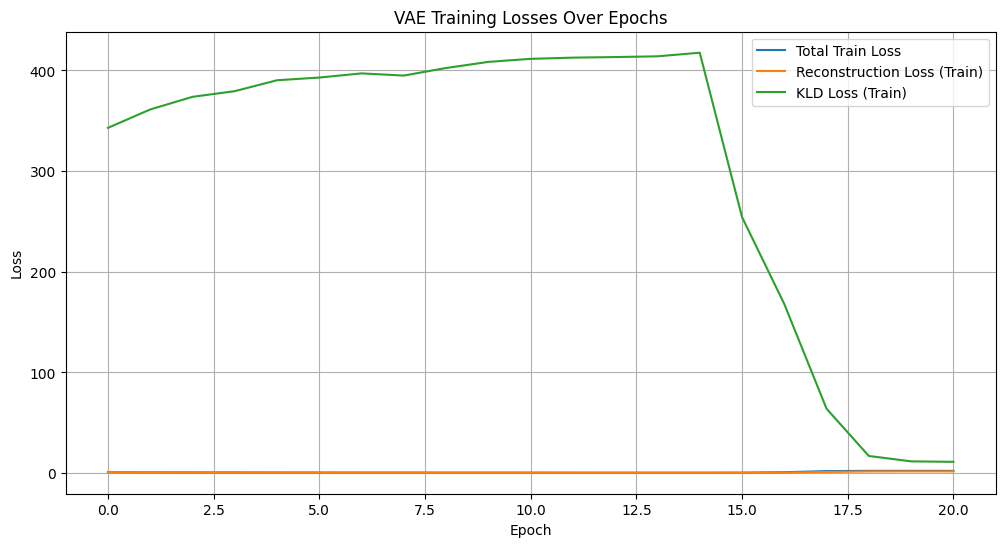

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.load_state_dict(torch.load("vae_model_epoch_1.pth", map_location=device))
# Run the training loop
train_losses, recon_losses, kld_losses = train_model( 
    model, train_dataloader, optimizer, 
    NUM_EPOCHS, KLD_START_EPOCH, KLD_END_EPOCH, PROP_START_EPOCH, PROP_END_EPOCH,
    device, model_save_path=MODEL_SAVE_PATH
)

# Plotting the losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Total Train Loss')
plt.plot(recon_losses, label='Reconstruction Loss (Train)')
plt.plot(kld_losses, label='KLD Loss (Train)')
# plt.plot(prop_losses, label='Property Loss (Train)')
plt.title('VAE Training Losses Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Now, we need a model which has a balanced reconstruction loss and KL divergence.[as low reconstruction loss means that model will generate accurate strings,while low kl divergence means sampling randomly from latent space will lead to valid molecules] 

Looking at the results, we can see that epoch 18 has good reconstruction loss and decent KL divergence(atleast compared to the other models). Hence, we use the model at epoch 11 for generating molecules.

## Sampling from latent space

Now, we will take 5000 random points from latent space and try to decode them into molecules. For each latent point, we perform stochastic write-out 1000 times (1000 attempts per point).

In [ ]:
model = SmilesVAE( latent_dim_zinc, hidden_gru_dim_zinc,
                   property_output_dim_zinc,
                   encoder_filter_sizes_zinc, encoder_kernel_sizes_zinc).to(device)
model.load_state_dict(torch.load("vae_model_epoch_18.pth", map_location=device))
unique_mols = set()
unique_smiles = set()
NUM_LATENT_POINTS = 1 
count = 0
for i in tqdm(range(5000),desc="Sampling Unique Molecules"):
    flag = False
    sampled_smiles, sampled_mols = sample_molecules(
        model, NUM_LATENT_POINTS,
        temperature=GENERATION_TEMPERATURE, device=device,num_stochastic_samples_per_latent_point=1000
    ) # for each point in latent space,do stochastic writeout 1000 times
    for i, (smi, mol) in enumerate(zip(sampled_smiles, sampled_mols)):
        validity = "VALID" if mol is not None else "INVALID"
        if mol is not None:
            unique_mols.add(mol)
            unique_smiles.add(smi)
            flag = True
    if flag:
        count += 1
        
        # print(f"{i+1}: {smi} ({validity})")

print(f"\nTotal unique valid SMILES generated: {len(unique_smiles)}") 
print(f"No of latent vectors which generated unique SMILES: {count}")
print(f"%age of latent vectors which generated unique SMILES: {(count)/5000:.2%}")




In [ ]:
import pickle
unique_smiles_list = list(unique_smiles)
unique_mols_list = list(unique_mols)
pickle.dump(unique_smiles_list, open("unique_smiles_list.pickle", "wb"))
pickle.dump(unique_mols, open("unique_mols.pickle", "wb"))
#save list of generated SMILES and RDKit molecules to pickle files(as they take some time to generate)

Around ~58% of latent vectors decode to valid smiles strings, which is decent considering we only trained on 10% of the dataset and didn't do a lot of hyperparamter tuning. The paper we are referencing got around 70% decoding rate for Zinc dataset.

In [12]:
import pickle
with open("unique_smiles_list.pickle", "rb") as f:
    unique_smiles_list = pickle.load(f)
with open("unique_mols.pickle", "rb") as f:
    unique_mols = pickle.load(f)

In [14]:
novelty = 0
for smile in unique_smiles_list:
    # print(smile)
    if smile in data_points_train_smiles:
        continue
    novelty += 1
print(f"%age Novelty of generated SMILES: {(novelty)/len(unique_smiles_list):.2%}")

%age Novelty of generated SMILES: 100.00%


All of the molecules generated are novel, which is a good sign that our molecule generalises well and is not just memorising smiles in dataset.

## Distribution of generated molecules

Distribution of length of SMILES strings

25904
[39, 41, 31, 37, 53, 49, 43, 44, 46, 29]


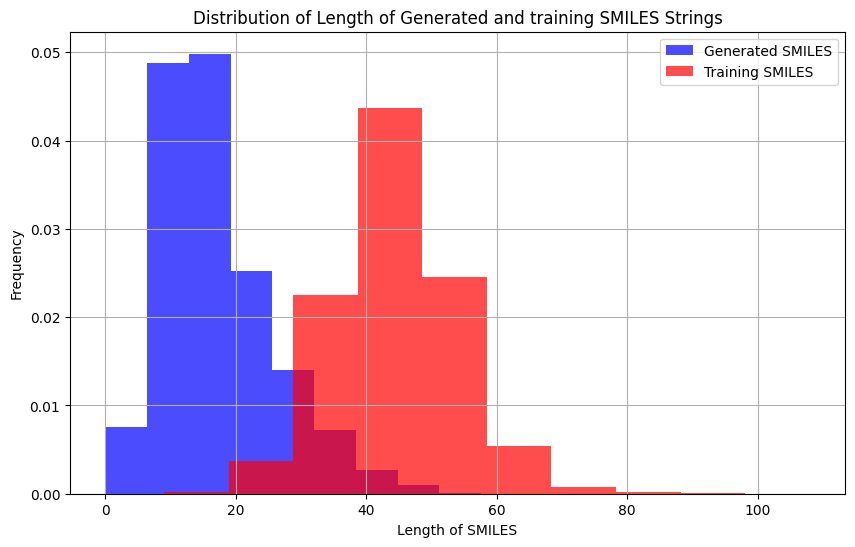

In [21]:
generated_num_atoms = []
generated_smiles_len = []
train_smiles_len = []

for dp in data_points_train_smiles:
    train_smiles_len.append(len(dp) - 1)  # Exclude start token

for i,smi in enumerate(unique_smiles_list):
    generated_smiles_len.append(len(smi))
print(len(generated_smiles_len))
print(train_smiles_len[:10])
plt.figure(figsize=(10, 6))
plt.hist(generated_smiles_len, bins=10, color='blue', alpha=0.7,density=True)
plt.hist(train_smiles_len, bins=10, color='red', alpha=0.7,density=True)
plt.title('Distribution of Length of Generated and training SMILES Strings')
plt.xlabel('Length of SMILES')
plt.ylabel('Frequency')
plt.legend(['Generated SMILES', 'Training SMILES'])
plt.grid()
plt.show()


Clearly, our generated smiles strings are a lot shorter than our training set smiles strings. This is a flaw of our model.

Distribution of number of atoms in molecules

Calculating Properties:   3%|▎         | 1367/41501 [00:01<00:38, 1037.52it/s]

Error calculating properties for molecule 1259: Can't kekulize mol.  Unkekulized atoms: 2 3 7


Calculating Properties: 100%|██████████| 41501/41501 [00:49<00:00, 840.85it/s] 


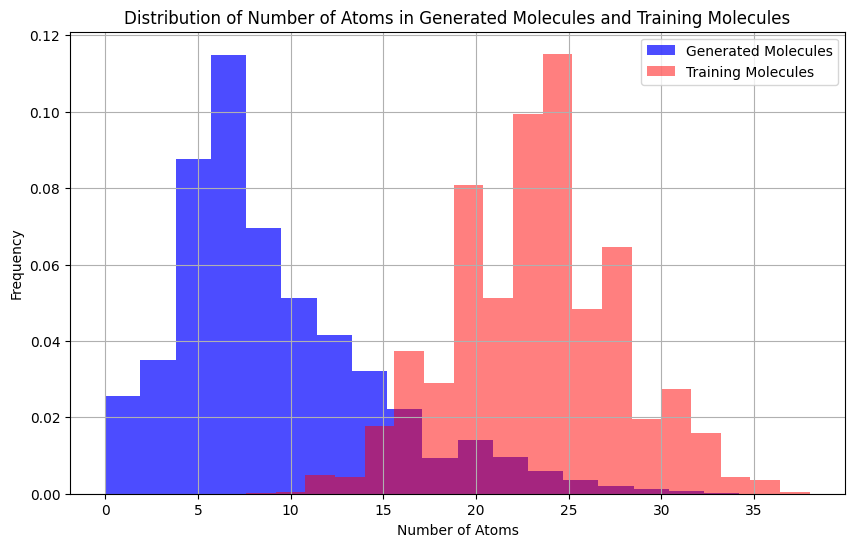

In [21]:
gen_logp = []
gen_qed = []
gen_sas = []

for i,mol in enumerate(tqdm((unique_mols),desc="Calculating Properties")):
    if mol is not None:
        try:
            generated_num_atoms.append(mol.GetNumAtoms())
            gen_logp.append(Descriptors.MolLogP(mol))
            gen_qed.append(QED.qed(mol))
        except Exception as e:
            print(f"Error calculating properties for molecule {i}: {e}")
            continue
        
plt.figure(figsize=(10, 6))
plt.hist(generated_num_atoms, bins=20, color='blue', alpha=0.7, density=True)
plt.hist(num_of_atoms, bins=20, color='red', alpha=0.5, density=True)
plt.title('Distribution of Number of Atoms in Generated Molecules and Training Molecules')
plt.xlabel('Number of Atoms')
plt.ylabel('Frequency')
plt.legend(['Generated Molecules', 'Training Molecules'])
plt.grid()
plt.show()

Similarly for number of atoms. (as expected).

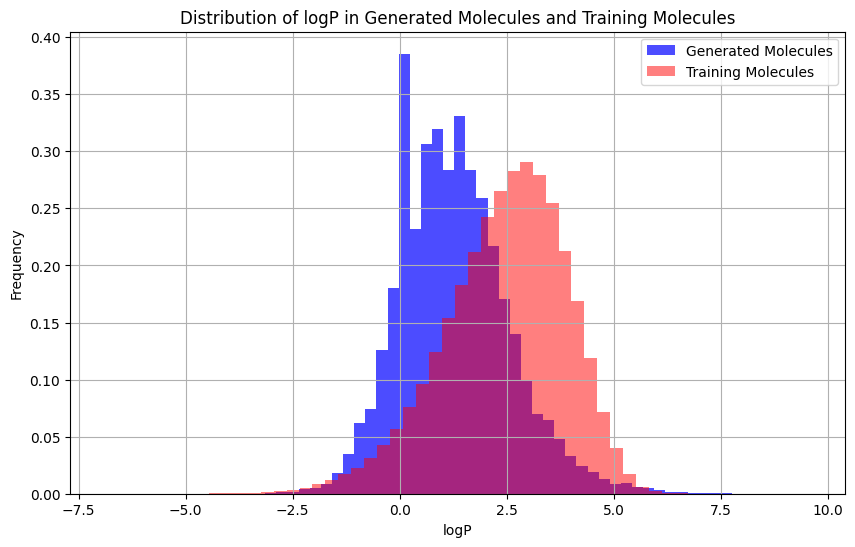

In [22]:
plt.figure(figsize=(10, 6))
plt.hist(gen_logp, bins=50, color='blue', alpha=0.7, density=True)
plt.hist(df['logP'], bins=50, color='red', alpha=0.5, density=True)
plt.title('Distribution of logP in Generated Molecules and Training Molecules')
plt.xlabel('logP')
plt.ylabel('Frequency')
plt.legend(['Generated Molecules', 'Training Molecules'])
plt.grid()
plt.show()

Our LogP distribution is fairly similar to training set.

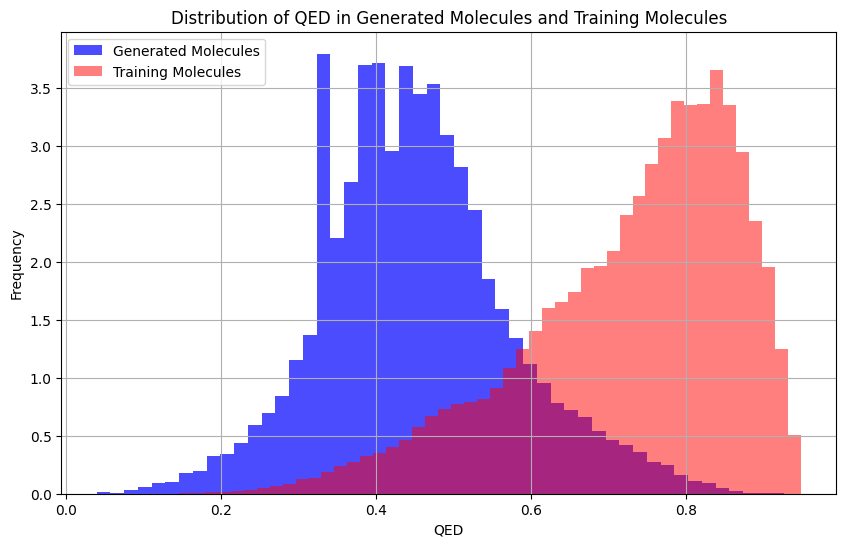

In [23]:
plt.figure(figsize=(10, 6))
plt.hist(gen_qed, bins=50, color='blue', alpha=0.7, density=True)
plt.hist(df['qed'], bins=50, color='red', alpha=0.5, density=True)
plt.title('Distribution of QED in Generated Molecules and Training Molecules')
plt.xlabel('QED')
plt.ylabel('Frequency')
plt.legend(['Generated Molecules', 'Training Molecules'])
plt.grid()
plt.show()

However, our QED distribution is very different than training distribution.

## Visualising molecules generated from latent space

Sample 1: COC1(CC=CC2CCC2C=S)C=NC=CCCCCCCC1


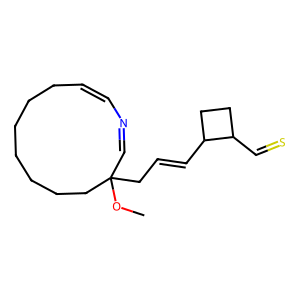

Sample 2: C=C1NCCNCC#CO[C@H]1CCC


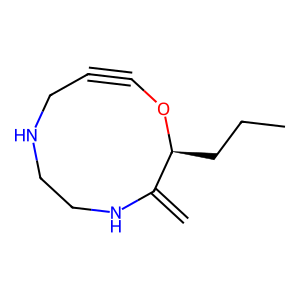

Sample 3: COCCCCCN


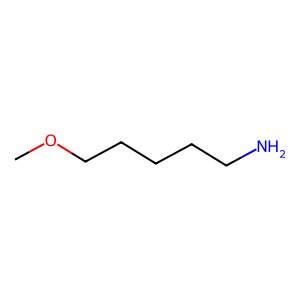

Sample 4: CCNCCCN1CCCCNNN2CN2NCCCC2CCC21C


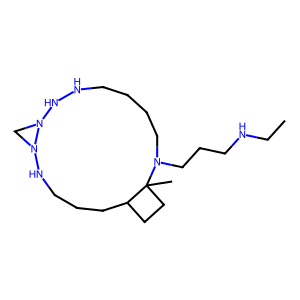

Sample 5: COC1=CC=Cc2c[nH]nc[nH]c(C=O)cnc1[nH]c2=O


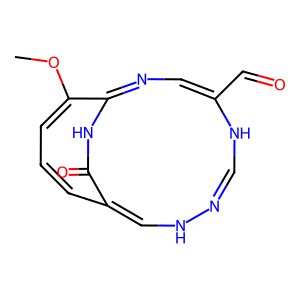

Sample 6: O=CC[CH]CCCO


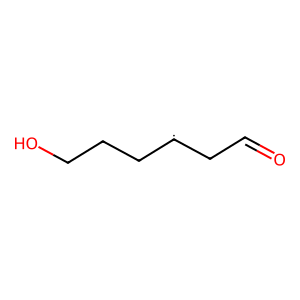

Sample 7: CCC1CC1S[SH](OC)OO


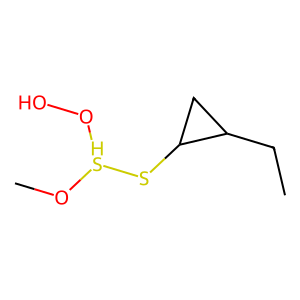

Sample 8: CCC1CCCN1C[NH+]1CCCCC1


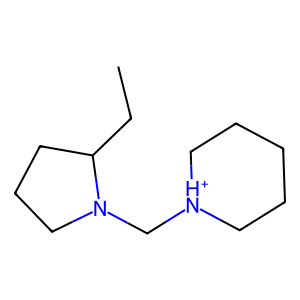

Sample 9: OC(I)C1CC1F


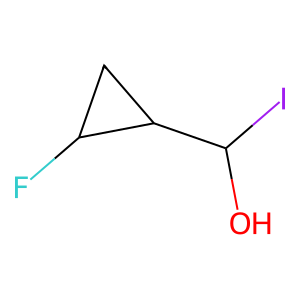

Sample 10: C#SSOC=S


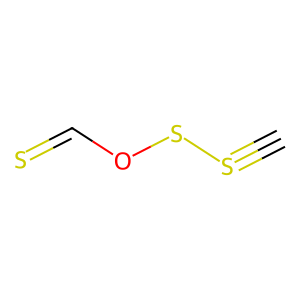

In [23]:

for i in range(10):
    idx = random.randint(0, len(unique_smiles_list) - 1)
    print(f"Sample {i+1}: {unique_smiles_list[idx]}")
    mol = Chem.MolFromSmiles(unique_smiles_list[idx])
    if mol is not None:
        img = Chem.Draw.MolToImage(mol, size=(300, 300))
        display(img)
    else:
        print("Invalid SMILES, cannot display molecule image.")

In [30]:
#Measuring character level accuracy
count =0
for batch_idx, (smiles_indices_batch, properties_batch) in enumerate(train_dataloader):
    smiles_indices_batch = smiles_indices_batch.to(device)
    properties_batch = properties_batch.to(device)

    # Forward pass
    recon_logits, mu, log_var, predicted_properties = model(smiles_indices_batch)
    # print(recon_logits.shape, mu.shape, log_var.shape, predicted_properties.shape,smiles_indices_batch.shape, properties_batch.shape)
    ave_accuracy = 0.0
    for i in range(smiles_indices_batch.size(0)):
        actual_smile = ""
        for idx in smiles_indices_batch[i]:
            if idx == 0 or idx == 35:
                break
            actual_smile += indice_to_char[idx.item()]
        # print(f"Actual SMILES sample {i}: {actual_smile}")   
        predicted_smile = ""
        for idx in recon_logits[i].argmax(dim=-1):
            if idx == 0 or idx == 35:
                break
            predicted_smile += indice_to_char[idx.item()]
        # print(f"Predicted SMILES sample {i}: {predicted_smile}")
        correct = 0
        for j in range(len(actual_smile)):
            if j >= len(predicted_smile):
                break
            if actual_smile[j] == predicted_smile[j]:
                correct += 1
        ave_accuracy += correct / len(actual_smile)
    ave_accuracy /= smiles_indices_batch.size(0)
    print(f"For Batch {batch_idx}, Average accuracy: {ave_accuracy}")
    count+=1
    if(count>5):
        break

    

For Batch 0, Average accuracy: 0.7321430653428392
For Batch 1, Average accuracy: 0.7383288480053964
For Batch 2, Average accuracy: 0.7316429849898891
For Batch 3, Average accuracy: 0.7366365369948248
For Batch 4, Average accuracy: 0.7086934201411001
For Batch 5, Average accuracy: 0.7225668238143458


Our model reconstructs around 75% of characters in smile strings accurately.